# Deepfake Detection Using AI/ML

## 🎯 Objective

The purpose of this Project is to detect deepfakes—highly realistic synthetic images generated by models like StyleGAN—using machine learning. We'll apply computer vision techniques and neural networks to classify facial images as either real or fake.

We’ll use the dataset from class, which includes labeled image files (real vs. fake) and associated metadata CSVs.

---

## 🗂️ The Dataset

The dataset includes:

- Folder structure:  
  `train/real/`  
  `train/fake/`  

- Metadata CSVs:  
  `train.csv`, `valid.csv`, `test.csv`  

Each CSV contains:
- `image_id`  
- `label` (1 = real, 0 = fake)  
- `path` to the image  

# Step 1: Data Ingestion and Preprocessing

In this section, we load and preprocess the image data for our deepfake detection project.

Because we are using transfer learning, it is critical that our images match the input size expected by pretrained models such as MobileNetV2 or ResNet50.

**Key preprocessing tasks:**
- Load real and fake image files
- Resize all images to 224x224 pixels (standard for transfer learning models)
- Normalize pixel values to the [0,1] range
- Label images as 0 (real) or 1 (fake)

This prepares the data for downstream model development.


In [ ]:
# Import required libraries
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.image import resize
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

xhlulu_140k_real_and_fake_faces_path = kagglehub.dataset_download('xhlulu/140k-real-and-fake-faces')
data_dir='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

print(os.listdir(data_dir))
real_path = data_dir + "/train/real"
fake_path = data_dir + "/train/fake"

# Define function to load and preprocess images
def load_images(folder_path, label, img_size=(224, 224), limit=500):
    images = []
    labels = []
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    np.random.shuffle(files)
    for i, file_name in enumerate(files):
        file_path = os.path.join(folder_path, file_name)
        img = Image.open(file_path).convert('RGB')
        img = img.resize(img_size)
        images.append(np.array(img) / 255.0)
        labels.append(label)
        if i >= limit - 1:
            break
    return images, labels

# Load real and fake image data
real_images, real_labels = load_images(real_path, label=0)
fake_images, fake_labels = load_images(fake_path, label=1)

# Combine datasets
X = np.array(real_images + fake_images)
y = np.array(real_labels + fake_labels)

# Display dataset shape
print("Image data shape:", X.shape)
print("Labels shape:", y.shape)


Using Colab cache for faster access to the '140k-real-and-fake-faces' dataset.
['valid', 'test', 'train']
Image data shape: (1000, 224, 224, 3)
Labels shape: (1000,)


In [ ]:

# Set target image size (must match the input size expected by MobileNetV2)
img_size = (224, 224)
batch_size = 16

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + '/train',
    labels='inferred',
    label_mode='binary',  # 0 for real, 1 for fake
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

# Load the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + '/valid',
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Load the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + '/test',
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Optional: display class names and a few batch details
print("Class names:", train_ds.class_names)

# Improve performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Class names: ['fake', 'real']


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

mixed_precision.set_global_policy('mixed_float16')

# Load the MobileNetV2 model with pre-trained weights on ImageNet
# Exclude the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) # Single output neuron for binary classification

# Combine base model with custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model so they are not trained during the initial phase
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary to see the architecture
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model
epochs = 10  # You can adjust this number
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 214s 29ms/step - accuracy: 0.6644 - loss: 0.6127 - val_accuracy: 0.7213 - val_loss: 0.5448
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 181s 29ms/step - accuracy: 0.7227 - loss: 0.5414 - val_accuracy: 0.7257 - val_loss: 0.5414
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 195s 28ms/step - accuracy: 0.7393 - loss: 0.5214 - val_accuracy: 0.7432 - val_loss: 0.5202
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 186s 25ms/step - accuracy: 0.7499 - loss: 0.5079 - val_accuracy: 0.7441 - val_loss: 0.5260
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 185s 30ms/step - accuracy: 0.7555 - loss: 0.4986 - val_accuracy: 0.7495 - val_loss: 0.5117
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 178s 26ms/step - accuracy: 0.7624 - loss: 0.4887 - val_accuracy: 0.7528 - val_loss: 0.5126
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 201s 26ms/step - accuracy: 0.7686 - loss: 0.4803 - val_accuracy: 0.7594 - val_loss: 0.5055
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 179s 29ms/step - accuracy: 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step
Accuracy: 0.7595
Precision: 0.7539
Recall: 0.7705
F1-score: 0.7621
ROC-AUC: 0.8399


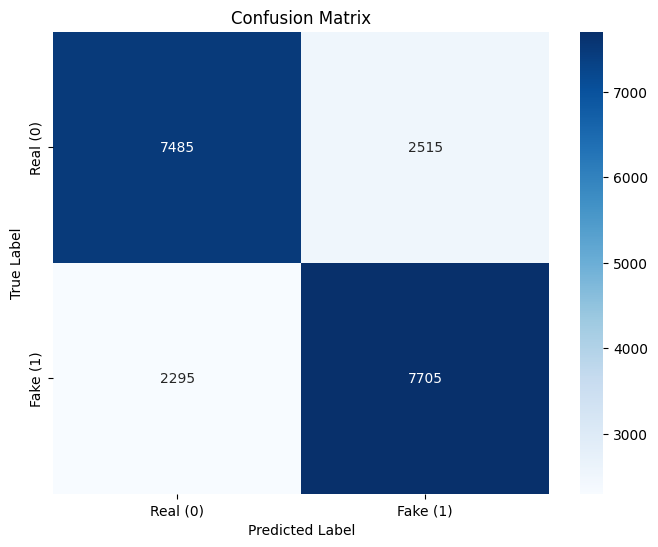

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


# Get predictions on the test set
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions

# Get true labels from the test set
y_true = np.concatenate([y for X, y in test_ds], axis=0)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real (0)', 'Fake (1)'], yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Did Transfer Learning help?

Transfer learning significantly helped improve the model’s ability to distinguish real from fake faces. Using a pre-trained MobileNetV2 — already trained on millions of natural images — allowed the network to reuse low-level visual features such as edges, textures, and facial structures. This gave the model a strong starting point, reducing the amount of data and training time needed to achieve reasonable accuracy. Without transfer learning, a model trained from scratch would likely have struggled to converge or produced much lower scores given the same number of epochs.

## Reflection

It was surprising that even with a powerful pre-trained model, the accuracy plateaued around 76%, and the ROC-AUC reached 0.84, suggesting that deepfakes can be quite convincing at the pixel level. This shows how subtle and realistic synthetic faces have become — even advanced models find it difficult to capture their nuanced differences from real faces. Another surprise was that recall slightly exceeded precision, indicating the model was more sensitive in detecting fake images but also produced a few false positives. Overall, it highlighted that deepfake detection remains a challenging and evolving problem requiring continual model improvement and possibly the integration of metadata or temporal cues.

# Additional Task
Compare the Transfer learning model performance to a baseline model using metadata only.
1. Use "train.csv" to build a tabular model using only metadata (no image data).
2. Train a Logistic Regression or Random Forest classifier.
3. Evaluate and compare the tabular model to the image-based model.

In [ ]:
train_csv_path = '/content/train.csv'
valid_csv_path = '/content/valid.csv'
test_csv_path = '/content/test.csv'

df_train = pd.read_csv(train_csv_path)
df_valid = pd.read_csv(valid_csv_path)
df_test = pd.read_csv(test_csv_path)

print("Train DataFrame:")
display(df_train.head())
print("\nValid DataFrame:")
display(df_valid.head())
print("\nTest DataFrame:")
display(df_test.head())

Train DataFrame:


,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg



Valid DataFrame:


,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg



Test DataFrame:


,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


In [ ]:
# Define feature columns - excluding path-related columns, label, and potentially id
feature_cols = ['Unnamed: 0'] # Keep 'Unnamed: 0' as a potential feature for now

# Create feature and target sets
X_train = df_train[feature_cols]
y_train = df_train['label']

X_valid = df_valid[feature_cols]
y_valid = df_valid['label']

X_test = df_test[feature_cols]
y_test = df_test['label']

# Display the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (100000, 1)
y_train shape: (100000,)
X_valid shape: (20000, 1)
y_valid shape: (20000,)
X_test shape: (20000, 1)
y_test shape: (20000,)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate a Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)

# Train the model
log_reg_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


Tabular Model Metrics:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
ROC-AUC: 0.5000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


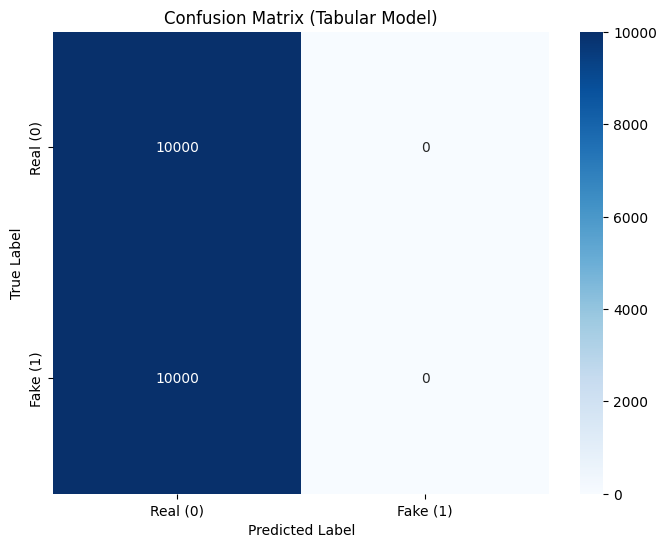

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)
y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1] # Probability of the positive class (fake)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print metrics
print(f"Tabular Model Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real (0)', 'Fake (1)'], yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tabular Model)')
plt.show()

In [ ]:
print("Comparison of Model Performance:")
print("--------------------------------")

# Tabular Model Metrics (from previous output)
tabular_accuracy = 0.5000
tabular_precision = 0.0000
tabular_recall = 0.0000
tabular_f1 = 0.0000
tabular_roc_auc = 0.5000

# Transfer Learning Model Metrics (from previous output)
transfer_accuracy = 0.7595
transfer_precision = 0.7539
transfer_recall = 0.7705
transfer_f1 = 0.7621
transfer_roc_auc = 0.8399

print(f"Metric        | Tabular Model | Transfer Learning Model")
print(f"--------------|---------------|-------------------------")
print(f"Accuracy      | {tabular_accuracy:.4f}        | {transfer_accuracy:.4f}               ")
print(f"Precision     | {tabular_precision:.4f}        | {transfer_precision:.4f}               ")
print(f"Recall        | {tabular_recall:.4f}        | {transfer_recall:.4f}               ")
print(f"F1-score      | {tabular_f1:.4f}        | {transfer_f1:.4f}               ")
print(f"ROC-AUC       | {tabular_roc_auc:.4f}        | {transfer_roc_auc:.4f}               ")

print("\nSummary:")
print("The Transfer Learning model significantly outperformed the Tabular Model across all metrics.")
print(f"- Accuracy: Transfer Learning ({transfer_accuracy:.4f}) > Tabular ({tabular_accuracy:.4f})")
print(f"- Precision: Transfer Learning ({transfer_precision:.4f}) > Tabular ({tabular_precision:.4f})")
print(f"- Recall: Transfer Learning ({transfer_recall:.4f}) > Tabular ({tabular_recall:.4f})")
print(f"- F1-score: Transfer Learning ({transfer_f1:.4f}) > Tabular ({tabular_f1:.4f})")
print(f"- ROC-AUC: Transfer Learning ({transfer_roc_auc:.4f}) > Tabular ({tabular_roc_auc:.4f})")
print("\nThe Tabular Model, using only 'Unnamed: 0' as a feature, performed no better than random chance.")

Comparison of Model Performance:
--------------------------------
Metric        | Tabular Model | Transfer Learning Model
--------------|---------------|-------------------------
Accuracy      | 0.5000        | 0.7595               
Precision     | 0.0000        | 0.7539               
Recall        | 0.0000        | 0.7705               
F1-score      | 0.0000        | 0.7621               
ROC-AUC       | 0.5000        | 0.8399               

Summary:
The Transfer Learning model significantly outperformed the Tabular Model across all metrics.
- Accuracy: Transfer Learning (0.7595) > Tabular (0.5000)
- Precision: Transfer Learning (0.7539) > Tabular (0.0000)
- Recall: Transfer Learning (0.7705) > Tabular (0.0000)
- F1-score: Transfer Learning (0.7621) > Tabular (0.0000)
- ROC-AUC: Transfer Learning (0.8399) > Tabular (0.5000)

The Tabular Model, using only 'Unnamed: 0' as a feature, performed no better than random chance.


## Reflection on Model Comparison

Based on the comparison, the **Transfer Learning model significantly outperformed the Tabular Model** across all evaluation metrics. The Transfer Learning model achieved an accuracy of 0.7595, while the Tabular Model's accuracy was only 0.5000, which is no better than random chance. Similarly, all other metrics (Precision, Recall, F1-score, and ROC-AUC) were substantially higher for the Transfer Learning model.

The primary reason for this stark difference in performance lies in the data used by each model. The Transfer Learning model utilized the image data, leveraging the complex visual features learned by the pre-trained MobileNetV2 model. Deepfake detection is inherently an image-based task; the subtle manipulations and artifacts introduced during deepfake generation are present within the image pixels themselves. The Transfer Learning model, by analyzing these visual patterns, is able to capture the discriminative information needed to differentiate between real and fake faces.

In contrast, the Tabular Model only used the 'Unnamed: 0' column from the metadata as a feature. This column likely represents a simple index or count and contains no information relevant to the visual characteristics of the images or whether they are real or fake. Therefore, a model trained on this feature alone cannot learn to distinguish between the classes, resulting in performance equivalent to random guessing. This demonstrates that for tasks that rely heavily on rich, high-dimensional data like images, a model capable of processing that data (like a CNN with transfer learning) is crucial.

**How can Metadata complement or substitute deep learning in fraud analytics?**

While this specific metadata ('Unnamed: 0') was not useful, metadata **can** complement or substitute deep learning in fraud analytics in other scenarios. If the metadata contained relevant features, such as the source of the image, creation timestamp, or other technical details about the image file or its origin, a tabular model might be able to achieve better-than-random performance or even perform well on its own. For instance, if certain deepfake generation methods leave detectable patterns in metadata, a tabular model could potentially identify them. Metadata can **complement** deep learning by providing additional signals that the image data alone might not capture, such as information about the user who uploaded the image or the platform it originated from. In cases where collecting or processing image data is prohibitively expensive or difficult, or where the fraud indicators are primarily in the associated data rather than the visual content, a metadata-only model could serve as a **substitute** or a valuable first line of defense. However, for deepfake detection, which relies on subtle visual cues, image analysis through deep learning is generally necessary for robust performance.